In [1]:
import csv

time, drag, lift = [], [], []
with open("Force_L_60/forces_aoa0.csv", newline="") as f:
    reader = csv.reader(f)        # reader 是可迭代的行
    header = next(reader)         # 如果有表头就先读掉
    for row in reader:            # row 是列表 → ["1.0", "0.23", "0.04"]
        t, d, l = map(float, row) # 字符串s转浮点s
        time.append(t)
        drag.append(d)
        lift.append(l)

print(time[:5], drag[:5], lift[:5])


[1.0, 1.1, 1.2, 1.3, 1.4] [-0.07940418695000252, -0.07932022480307428, -0.07907008872462669, -0.07846153132069134, -0.07811333562829456] [-0.008037301685338305, -0.007523782287760131, -0.007391702972304526, -0.008173890441223564, -0.007957488941686009]


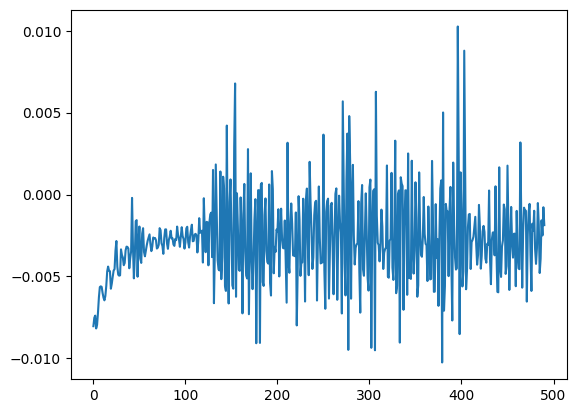

In [2]:
import matplotlib.pyplot as plt
plt.plot(lift)

In [3]:
# coeff_utils.py
import csv, numpy as np
from scipy.signal import find_peaks
from math import lcm

# ---------- 可调整的默认参数 ----------
SKIP_VAR_WIN  = 200      # 滑动窗口长度 (点)
VAR_THRESH_P  = 0.05    # 方差阈值占最大值的比例
PK_DIST_FRAC  = 0.4     # 峰间最小间距占半周期比例
CYCLES_MIN    = 10       # 求平均时至少包含的公共周期数量

# ---------- 核心函数 ----------
def mean_cd_cl(csv_path: str,
               skip_var_win: int  = SKIP_VAR_WIN,
               var_thresh_ratio: float = VAR_THRESH_P,
               pk_frac: float    = PK_DIST_FRAC,
               cycles_min: int   = CYCLES_MIN,
               return_window=False):
    """
    读取 3 列 CSV (time, drag, lift)，自动:
      1) 删除前期非稳态段
      2) 估计 Cd、Cl 基频
      3) 截取公共整周期窗
      4) 计算平均 Cd、Cl
    返回 dict；若 return_window=True，再额外返回用于平均的掩码数组。
    """
    # 1. 读文件 --------------------------------------------------------------
    time, Cd, Cl = [], [], []
    with open(csv_path, newline="") as f:
        rdr = csv.reader(f); next(rdr)
        for row in rdr:
            t, d, l = map(float, row)
            time.append(t); Cd.append(d); Cl.append(l)
    time, Cd, Cl = map(np.asarray, (time, Cd, Cl))

    # 2. 非稳态裁剪 -----------------------------------------------------------
    var_series = np.array([Cd[i:i+skip_var_win].var()
                           for i in range(len(Cd)-skip_var_win)])
    thr        = var_thresh_ratio * var_series.max()
    start_idx  = np.argmax(var_series < thr) + skip_var_win
    t, Cd, Cl  = time[start_idx:], Cd[start_idx:], Cl[start_idx:]

    # 3. 估计周期 -------------------------------------------------------------
    def _period(sig):
        dt  = np.mean(np.diff(t))
        min_dist = max(int(len(sig)*pk_frac/10), 5)
        pk, _ = find_peaks(sig, distance=min_dist)
        if len(pk) < 2:
            raise RuntimeError(f"峰值不足，无法估计周期 in {csv_path}")
        return np.mean(np.diff(t[pk]))

    T_Cd = _period(Cd)
    T_Cl = _period(np.abs(Cl))

    # 4. 公共窗口 & 平均 -------------------------------------------------------
    dt   = np.mean(np.diff(t))
    P_Cd = int(round(T_Cd/dt))
    P_Cl = int(round(T_Cl/dt))
    Pcom = lcm(P_Cd, P_Cl)             # 公共周期点数
    win  = max(Pcom, Pcom*cycles_min)  # 至少 cycles_min 个公共周期
    mask = t >= (t[-1] - win*dt)

    Cd_mean, Cl_mean = Cd[mask].mean(), Cl[mask].mean()

    result = dict(csv=csv_path,
                  Cd_mean=Cd_mean,
                  Cl_mean=Cl_mean,
                  steady_start=float(time[start_idx]),
                  T_Cd=float(T_Cd),
                  T_Cl=float(T_Cl))

    if return_window:
        result["mask"] = mask
        result["t"]    = t
        result["Cd"]   = Cd
        result["Cl"]   = Cl
    return result


In [11]:

AOA = [0,8,10,15,20]
for aoa in AOA:
    csv_path = f"Force_L_60/forces_aoa{aoa}.csv"   # 换成你自己的
    info = mean_cd_cl(csv_path)

    print(f"aoa{aoa}=== 结果 ===")
    for k, v in info.items():
        if k != "csv":
            print(f"{k:>12} : {v}")


aoa0=== 结果 ===
     Cd_mean : -0.07359862534977321
     Cl_mean : -0.002464165045143259
steady_start : 23.7
        T_Cd : 1.27
        T_Cl : 1.5
aoa8=== 结果 ===
     Cd_mean : -0.11050649649246698
     Cl_mean : -0.32740738900090893
steady_start : 34.8
        T_Cd : 1.125
        T_Cl : 1.1153846153846154
aoa10=== 结果 ===
     Cd_mean : -0.14222232485358954
     Cl_mean : -0.4201201617987167
steady_start : 21.0
        T_Cd : 1.1782608695652175
        T_Cl : 1.179166666666667
aoa15=== 结果 ===
     Cd_mean : -0.2858475008078959
     Cl_mean : -0.7637071894901594
steady_start : 21.0
        T_Cd : 1.4833333333333334
        T_Cl : 1.4842105263157892
aoa20=== 结果 ===
     Cd_mean : -0.40250599910200735
     Cl_mean : -0.8001284688121675
steady_start : 21.0
        T_Cd : 2.0153846153846158
        T_Cl : 2.0923076923076924


In [12]:
Cd_aoa = [0.07,0.11,0.14,0.28,0.40]
Cl_aoa = [0.0024,0.32,0.42,0.76,0.80]
aoa = [0,8,10,15,20]

Paper_cd = [0.12,0.16, 0.18,0.28,0.43]
Paper_cl = [0.0,0.35, 0.45,0.75,0.78]


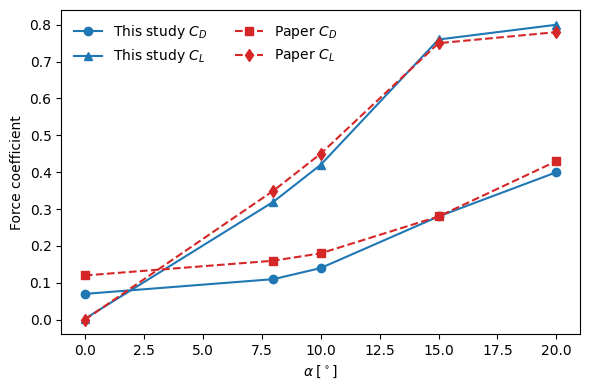

In [13]:
import matplotlib.pyplot as plt

# 统一配色 / 线型
color_study  = "tab:blue"     # 本研究
color_paper  = "tab:red"      # 文献
style_study  = "-"            # 实线
style_paper  = "--"           # 虚线

plt.figure(figsize=(6,4))

# ----- 本研究 -----
plt.plot(aoa, Cd_aoa, linestyle=style_study, color=color_study,
         marker='o',  label=r"This study $C_D$")
plt.plot(aoa, Cl_aoa, linestyle=style_study, color=color_study,
         marker='^',  label=r"This study $C_L$")

# ----- 文献 -----
plt.plot(aoa, Paper_cd, linestyle=style_paper, color=color_paper,
         marker='s',  label=r"Paper $C_D$")
plt.plot(aoa, Paper_cl, linestyle=style_paper, color=color_paper,
         marker='d',  label=r"Paper $C_L$")

plt.xlabel(r"$\alpha\;[^\circ]$")
plt.ylabel(r"Force coefficient")
plt.legend(frameon=False, ncol=2)   # ncol=2 可把 legend 分两列排整齐
plt.tight_layout()
plt.show()
